In [11]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN
from keras.models import Sequential
from tensorflow import keras
from keras.optimizers import Adam
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.svm import SVR

In [12]:
from google.colab import files
uploaded = files.upload()

Saving Bali 2015 - 2022.csv to Bali 2015 - 2022.csv


# Prepare

In [13]:
df = pd.read_csv('Bali 2015 - 2022.csv')
df = df[['datetime', 'total_accomodation', 'total_visitor']]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   datetime            108 non-null    object
 1   total_accomodation  108 non-null    int64 
 2   total_visitor       108 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB


In [15]:
df.describe()

,total_accomodation,total_visitor
count,108.000000,108.000000
mean,36224.250000,314491.694444
std,11955.946508,197701.212263
min,16495.000000,0.000000
25%,26054.250000,178084.000000
50%,35928.000000,358883.500000
75%,46455.750000,461889.250000
max,58302.000000,624366.000000


In [16]:
# datetime to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
train_datetime = df['datetime']
df = df.set_index(['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   total_accomodation  108 non-null    int64
 1   total_visitor       108 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB


<Axes: xlabel='datetime'>

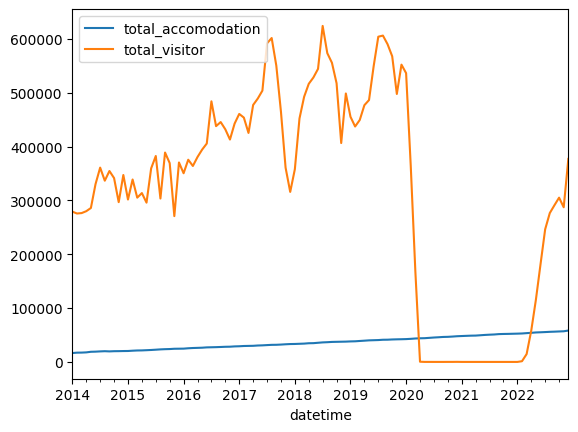

In [17]:
df.plot(legend=True)

In [18]:
# standarisasi
features = ['total_visitor', 'total_accomodation']
ct = ColumnTransformer([
    ('Std', StandardScaler(), features)
    ], remainder='passthrough')
df_scaled = df.copy()
df_scaled[features] = ct.fit_transform(df_scaled[features])

In [19]:
# Sliding Window
sequence_length = 3
d_tf = tf.keras.utils.timeseries_dataset_from_array(df_scaled.values, targets=df_scaled['total_visitor'][sequence_length:].values, sequence_length=sequence_length)
X = []
y = []
for X_batch, y_batch in d_tf:
    X.append(X_batch.numpy())
    y.append(y_batch.numpy())
X = np.array(X)
y = np.array(y)

# 80:20

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.2, shuffle=False)

In [ ]:
# Model
model = Sequential()
model.add(SimpleRNN(24, activation="leaky_relu", return_sequences=False, input_shape=(sequence_length, 2)))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_421 (SimpleRNN)  (None, 24)                648       
                                                                 
 dense_248 (Dense)           (None, 1)                 25        
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=100, batch_size=12, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 2s 75ms/step - loss: 0.9081 - val_loss: 5.6585
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 0.7522 - val_loss: 5.2028
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6281 - val_loss: 4.8486
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5311 - val_loss: 4.5437
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4305 - val_loss: 4.2980
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.3452 - val_loss: 4.0985
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2701 - val_loss: 3.9374
Epoch 8/100
6/6 [==============================] - 0s 16ms/step - loss: 0.2062 - val_loss: 3.8097
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.1625 - val_loss: 3.7300
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1293 - val_loss: 3.6901
Epoch 11/100
6/6 [=

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 226ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = -4.870612861244239
MSE:  2.6628351813673
MAPE:  3.6316086645627688
MAE:  1.5926789436555073


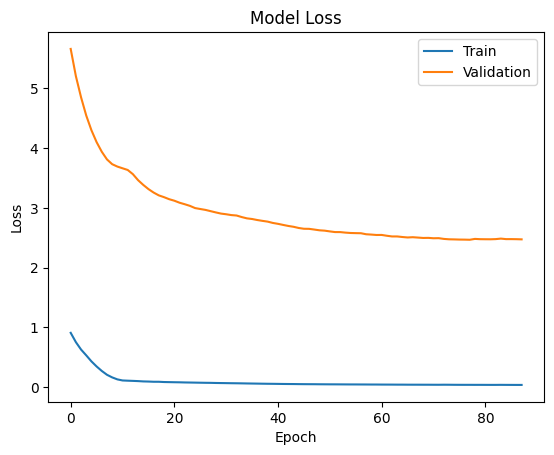

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

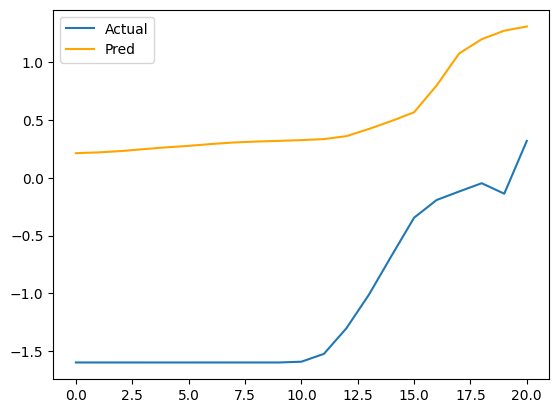

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, X.shape[3]))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
RNN8020= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
RNN8020['Time'] = pd.to_datetime(RNN8020['Time'])
RNN8020= RNN8020.set_index(['Time'])
RNN8020['temp'] = 0

1/1 [==============================] - 0s 32ms/step


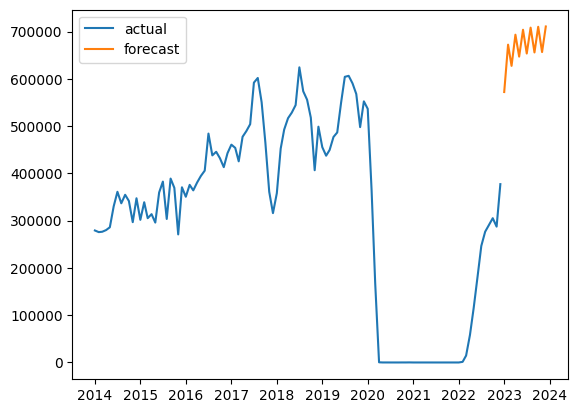

In [ ]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(RNN8020.index, ct.named_transformers_['Std'].inverse_transform(RNN8020)[:,0], label='forecast')
plt.legend()

# 70:30

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.3, shuffle=False)

In [ ]:
# Model
model = Sequential()
model.add(SimpleRNN(256, activation="leaky_relu", return_sequences=True, input_shape=(sequence_length, 2)))
model.add(SimpleRNN(128, activation="leaky_relu", return_sequences=False))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_239 (SimpleRNN)  (None, 3, 256)            66304     
                                                                 
 simple_rnn_240 (SimpleRNN)  (None, 128)               49280     
                                                                 
 dense_159 (Dense)           (None, 1)                 129       
                                                                 
Total params: 115,713
Trainable params: 115,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=100, batch_size=12, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 4s 103ms/step - loss: 0.2783 - val_loss: 0.6341
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 0.1294 - val_loss: 0.4333
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0862 - val_loss: 0.3659
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0770 - val_loss: 0.3364
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0595 - val_loss: 0.3250
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0550 - val_loss: 0.2843
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0485 - val_loss: 0.2662
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0478 - val_loss: 0.2683
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0461 - val_loss: 0.2687
Epoch 10/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0454 - val_loss: 0.2620
Epoch 11/100
5/5 [

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 376ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.5908386446380149
MSE:  0.1468941415402794
MAPE:  0.5798841269750846
MAE:  0.35677558594856573


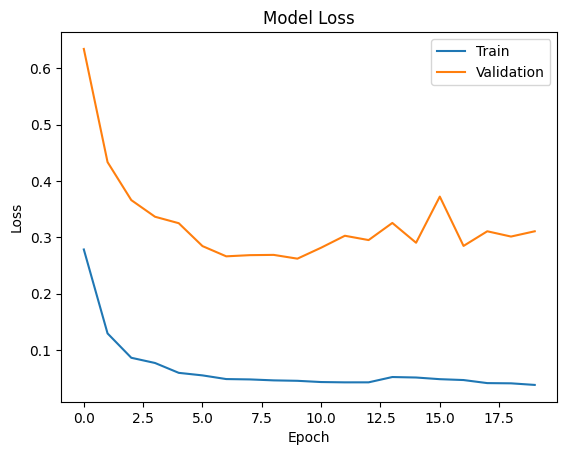

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

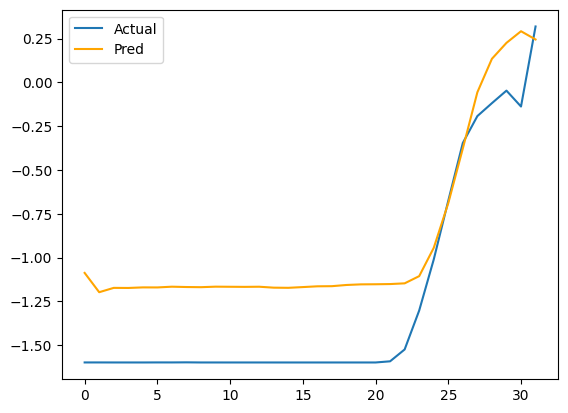

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, X.shape[3]))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
RNN7030= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
RNN7030['Time'] = pd.to_datetime(RNN7030['Time'])
RNN7030 = RNN7030.set_index(['Time'])
RNN7030['temp'] = 0

1/1 [==============================] - 0s 33ms/step


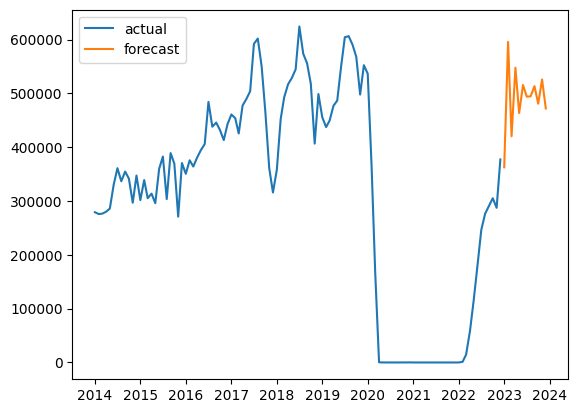

In [ ]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(RNN7030.index, ct.named_transformers_['Std'].inverse_transform(RNN7030)[:,0], label='forecast')
plt.legend()

# 60:40

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.4, shuffle=False)

In [ ]:
# Model
model = Sequential()
model.add(SimpleRNN(216, activation="tanh", return_sequences=True, input_shape=(sequence_length, 2)))
model.add(SimpleRNN(216, activation="tanh", return_sequences=False))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_248"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_418 (SimpleRNN)  (None, 3, 216)            47304     
                                                                 
 simple_rnn_419 (SimpleRNN)  (None, 216)               93528     
                                                                 
 dense_246 (Dense)           (None, 1)                 217       
                                                                 
Total params: 141,049
Trainable params: 141,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=10, batch_size=12, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
5/5 [==============================] - 3s 98ms/step - loss: 0.8085 - val_loss: 0.1334
Epoch 2/10
5/5 [==============================] - 0s 15ms/step - loss: 0.3160 - val_loss: 0.4056
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.1774 - val_loss: 0.1103
Epoch 4/10
5/5 [==============================] - 0s 18ms/step - loss: 0.1762 - val_loss: 0.2065
Epoch 5/10
5/5 [==============================] - 0s 16ms/step - loss: 0.1394 - val_loss: 0.0685
Epoch 6/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0635 - val_loss: 0.1819
Epoch 7/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0813 - val_loss: 0.0712
Epoch 8/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0808 - val_loss: 0.0919
Epoch 9/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0615 - val_loss: 0.1628
Epoch 10/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0880 - val_loss: 0.0817


In [ ]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.828153876120853
MSE:  0.2055150101153707
MAPE:  0.5300605693570406
MAE:  0.40506106008779674


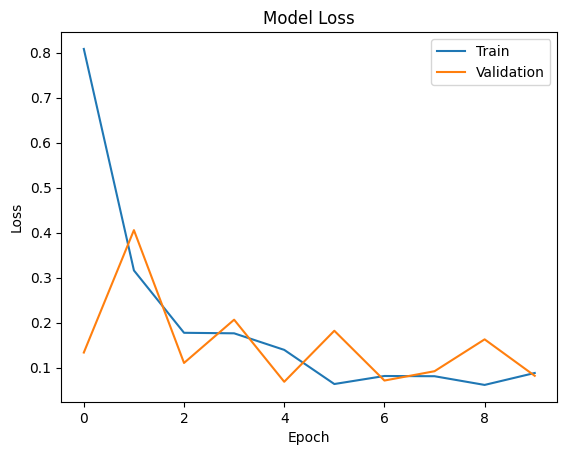

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

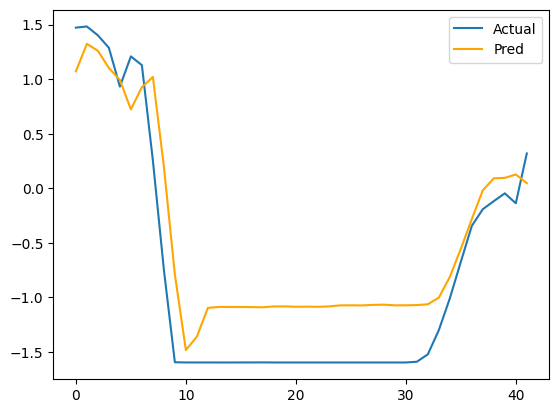

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, X.shape[3]))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
RNN6040= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
RNN6040['Time'] = pd.to_datetime(RNN6040['Time'])
RNN6040 = RNN6040.set_index(['Time'])
RNN6040['temp'] = 0

1/1 [==============================] - 0s 24ms/step


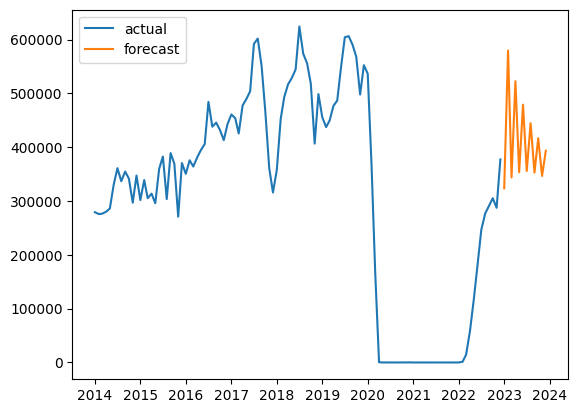

In [ ]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(RNN6040.index, ct.named_transformers_['Std'].inverse_transform(RNN6040)[:,0], label='forecast')
plt.legend()

# SVR

In [214]:
# X, y
X = df_scaled.values
y = df_scaled['total_visitor'].values

## 80:20

In [245]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [246]:
# Regresor
regressor = SVR(kernel='rbf', C=1, epsilon=0.01)
regressor.fit(X_train, y_train)

SVR(C=1, epsilon=0.01)

In [247]:
y_pred = regressor.predict(X_test)

In [248]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.9462741952838406
MSE:  0.02389598038581351
MAPE:  0.16788346373192556
MAE:  0.13285318398453153


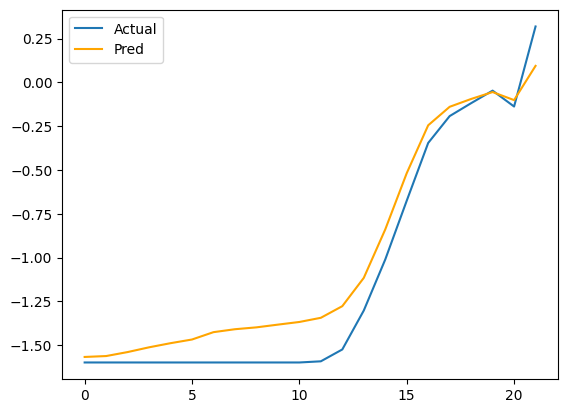

In [249]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [250]:
# Forecasts
last_sequence = X[-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape(1,-1)
    forecast = regressor.predict(input_sequence)
    forecasts.append(forecast[0])

    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = forecast[0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
SVR8020 = pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
SVR8020['Time'] = pd.to_datetime(SVR8020['Time'])
SVR8020 = SVR8020.set_index(['Time'])
SVR8020['temp'] = 0

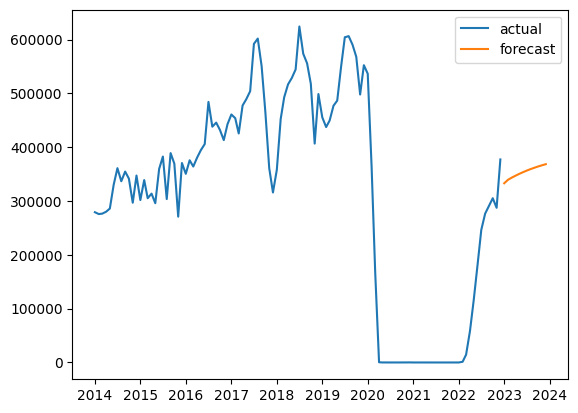

In [251]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(SVR8020.index, ct.named_transformers_['Std'].inverse_transform(SVR8020)[:,0], label='forecast')
plt.legend()

## 70:30

In [435]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [529]:
# Regresor
regressor = SVR(kernel='linear', C=100, epsilon=0.1)
regressor.fit(X_train, y_train)

SVR(C=100, kernel='linear')

In [530]:
y_pred = regressor.predict(X_test)

In [531]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.9386225736686807
MSE:  0.02157662776882338
MAPE:  0.11141480469143053
MAE:  0.13538949298677308


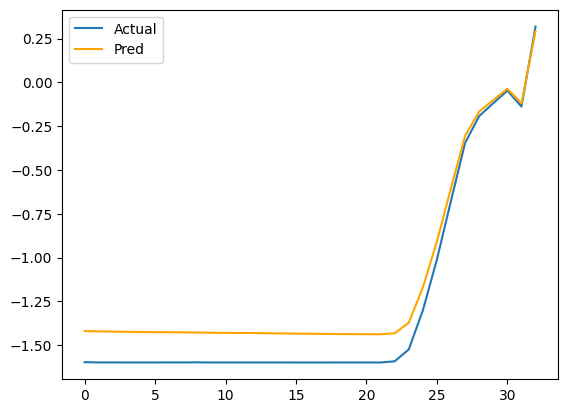

In [532]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [533]:
# Forecasts
last_sequence = X[-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape(1,-1)
    forecast = regressor.predict(input_sequence)
    forecasts.append(forecast[0])

    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = forecast[0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
SVR7030 = pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
SVR7030['Time'] = pd.to_datetime(SVR7030['Time'])
SVR7030 = SVR7030.set_index(['Time'])
SVR7030['temp'] = 0

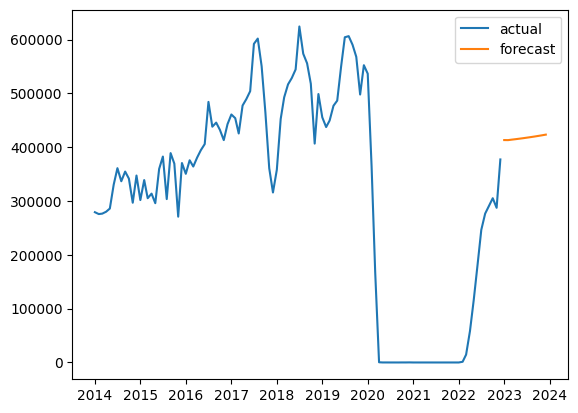

In [519]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(SVR7030.index, ct.named_transformers_['Std'].inverse_transform(SVR7030)[:,0], label='forecast')
plt.legend()

## 60:40

In [534]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

In [567]:
# Regresor
regressor = SVR(kernel='linear', C=1, epsilon=0.1)
regressor.fit(X_train, y_train)

SVR(C=1, kernel='linear')

In [568]:
y_pred = regressor.predict(X_test)

In [569]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.9317819602845547
MSE:  0.08785240058517216
MAPE:  0.381319223532396
MAE:  0.2638868828126725


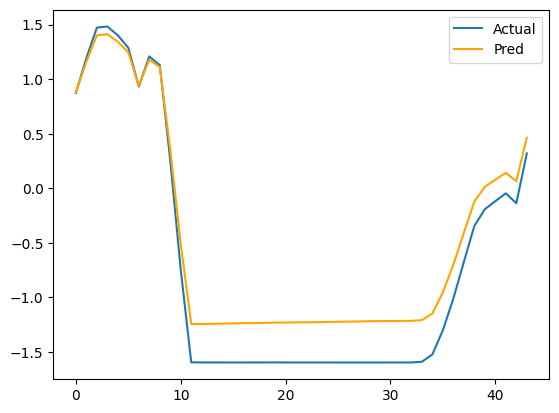

In [570]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [571]:
# Forecasts
last_sequence = X[-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape(1,-1)
    forecast = regressor.predict(input_sequence)
    forecasts.append(forecast[0])

    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = forecast[0]

from datetime import datetime, timedelta

last_date = df.index[-1]
time_step = relativedelta(months=1)
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
SVR6040 = pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
SVR6040['Time'] = pd.to_datetime(SVR6040['Time'])
SVR6040 = SVR6040.set_index(['Time'])
SVR6040['temp'] = 0

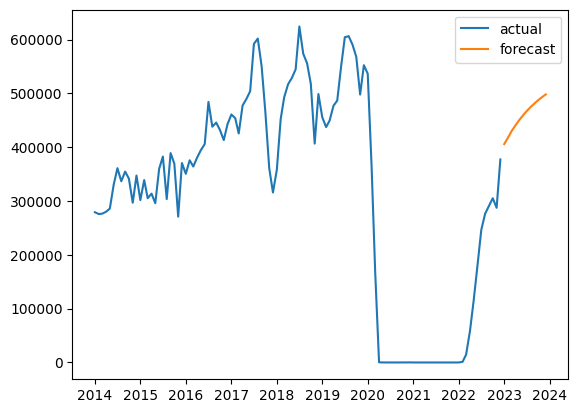

In [572]:
plt.plot(df['total_visitor'], label='actual')
plt.plot(SVR6040.index, ct.named_transformers_['Std'].inverse_transform(SVR6040)[:,0], label='forecast')
plt.legend()